<a href="https://colab.research.google.com/github/Necromancer19/PracticalDS/blob/main/ai_2025_missing_pixels_DIY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/dmc27/missing_pixels.git

Cloning into 'missing_pixels'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 56 (from 1)
Receiving objects: 100% (59/59), 11.59 MiB | 17.66 MiB/s, done.


In [ ]:
import os.path
from os import listdir
from os.path import isfile, join

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 96

from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style> body {font-size: 18px;}'''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

NUM_INP_NODES = 60
NUM_HID_NODES = 6
NUM_OUT_NODES = 4
BLOCK_SIZE = 8
CONTEXT_BLOCK_SIZE = 8
M1 = 3
M2 = 4

In [ ]:
# utility function to decide if a pixel is missing or not
def is_missing_pixel(r, c):
  return (r >= M1 and c >= M1 and r <= M2 and c <= M2)
#-------------------------------------------------------------------------------

# parses an image's 8x8 blocks into input and target vectors;
# appends these vectors to the inps and tgts list
def do_parse_img(img, inps, tgts):
  num_rows = img.shape[0]
  num_cols = img.shape[1]

  inp = np.zeros((NUM_INP_NODES))
  tgt = np.zeros((NUM_OUT_NODES))

  for r0 in range(0, num_rows, BLOCK_SIZE):
    for c0 in range(0, num_cols, BLOCK_SIZE):
      # extract and reshape a block of the image
      pos1 = 0
      pos2 = 0
      for r in range(BLOCK_SIZE):
        for c in range(BLOCK_SIZE):
          assert(r0 + r < num_rows)
          assert(c0 + c < num_cols)

          if is_missing_pixel(r, c):
            tgt[pos2] = img[r0 + r, c0 + c]
            pos2 += 1
          else:
            inp[pos1] = img[r0 + r, c0 + c]
            pos1 += 1

      # add the input and target patterns
      inps.append(inp.copy() / 255.0)
      tgts.append(tgt.copy() / 255.0)
#-------------------------------------------------------------------------------

# computes the MLP response (all output nodes) for a given input (inp);
# returns the responses (y values) of the output nodes (out) and the hidden
# nodes (hid)
def neural_response(inp, wh, bh, wo, bo):
  num_inp_nodes = wh.shape[1]
  num_hid_nodes = wh.shape[0]
  num_out_nodes = wo.shape[0]

  hid = np.zeros((num_hid_nodes))
  out = np.zeros((num_out_nodes))

  # compute the hidden layer activation (output)
  for h_idx in range(num_hid_nodes):
    val = bh[h_idx]
    for i_idx in range(num_inp_nodes):
      val += wh[h_idx, i_idx] * inp[i_idx]

    hid[h_idx] = 1.0 / (1.0 + np.exp(-val))

  # compute the output layer activation
  for o_idx in range(num_out_nodes):
    val = bo[o_idx]
    for h_idx in range(num_hid_nodes):
      val += wo[o_idx, h_idx] * hid[h_idx]

    out[o_idx] = 1.0 / (1.0 + np.exp(-val))

  # return the output
  return (hid, out)
#-------------------------------------------------------------------------------

def compute_gradients(inp, hid, out, err, wh, wo):
  num_inp_nodes = wh.shape[1]
  num_hid_nodes = wh.shape[0]
  num_out_nodes = wo.shape[0]

  grd_out_w = np.zeros((num_out_nodes, num_hid_nodes))
  grd_out_b = np.zeros(num_out_nodes)
  grd_hid_w = np.zeros((num_hid_nodes, num_inp_nodes))
  grd_hid_b = np.zeros(num_hid_nodes)

  # compute (negative) gradients for output weights/biases
  for o_idx in range(num_out_nodes):
    grd_out_b[o_idx] = err[o_idx]*out[o_idx]*(1.0 - out[o_idx])

    for h_idx in range(num_hid_nodes):
      grd_out_w[o_idx, h_idx] = grd_out_b[o_idx]*hid[h_idx]

  # compute (negative) gradients for hidden weights/biases
  for h_idx in range(num_hid_nodes):
    for o_idx in range(num_out_nodes):
      grd_hid_b[h_idx] += grd_out_b[o_idx]*wo[o_idx, h_idx]

    grd_hid_b[h_idx] *= hid[h_idx]*(1.0 - hid[h_idx])

    for i_idx in range(num_inp_nodes):
      grd_hid_w[h_idx, i_idx] = grd_hid_b[h_idx]*inp[i_idx]

  return (grd_out_w, grd_out_b, grd_hid_w, grd_hid_b)
#-------------------------------------------------------------------------------

def update_network(wh, bh, wo, bo,
                   grd_out_w, grd_out_b, grd_hid_w, grd_hid_b,
                   lrate):
  num_inp_nodes = wh.shape[1]
  num_hid_nodes = wh.shape[0]
  num_out_nodes = wo.shape[0]

  # adjust wo
  for h_idx in range(num_hid_nodes):
    for o_idx in range(num_out_nodes):
      wo[o_idx, h_idx] += lrate * grd_out_w[o_idx, h_idx]

  # adjust bo
  for o_idx in range(num_out_nodes):
    bo[o_idx] += lrate * grd_out_b[o_idx]

  # adjust wh
  for i_idx in range(num_inp_nodes):
    for h_idx in range(num_hid_nodes):
      wh[h_idx, i_idx] += lrate * grd_hid_w[h_idx, i_idx]

  # adjust bh
  for h_idx in range(num_hid_nodes):
    bh[h_idx] += lrate * grd_hid_b[h_idx]

#-------------------------------------------------------------------------------

def imshow(img, cmap=None, vmin=0, vmax=255, frameon=False, dpi=72):
  fig = plt.figure(figsize=[img.shape[1]/dpi, img.shape[0]/dpi], \
                   frameon=frameon)
  ax = fig.add_axes([0, 0, 1, 1])
  ax.axis('off')
  ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.show()


In [ ]:
# @title LOAD THE TRAINING DATA
img_path = "/content/missing_pixels"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
print(img_fnames)

inps = []
tgts = []
num_imgs = 0
for img_fname in img_fnames:

  # skip the image(s) used for testing
  if (img_fname.lower() == "balloon.bmp"):
    continue

  print(img_fname)
  img = cv.imread(join(img_path, img_fname), cv.IMREAD_GRAYSCALE)
  img = cv.resize(img, (256, 256), cv.INTER_LINEAR)
  img = img.astype(np.float64)

  do_parse_img(img, inps, tgts)

  num_imgs += 1
  if (num_imgs > 25):
    break

print("num_imgs =", num_imgs)

X_trn = np.zeros((len(inps), NUM_INP_NODES))
y_trn = np.zeros((len(tgts), NUM_OUT_NODES))
for idx in range(len(inps)):
  X_trn[idx, :] = inps[idx]
  y_trn[idx] = tgts[idx]


['sealion.bmp', 'beans.bmp', 'TRAIN.BMP', 'horse.bmp', 'balloon.bmp', 'deer.bmp', 'dune2.bmp', 'PUMPKINS.BMP', 'baboon.bmp', 'HOUSE.BMP', 'lena.bmp', 'bark.bmp', 'birds.bmp', 'hawaii.bmp', 'zelda.bmp', 'desert.bmp', 'valley.bmp', 'FLOWERS.BMP', 'airplane.bmp', 'FOOTBALL.BMP', 'TABLE.BMP', 'barbara.bmp', 'branches.bmp', 'KIDS.BMP', 'sheep.bmp', 'duck.bmp', 'man.bmp', 'bricks.bmp', 'helen.bmp', 'lily.bmp', 'stream.bmp', 'rooster.bmp', 'pelicans.bmp', 'rainriver.bmp', 'WALL.BMP', 'buds.bmp', 'tulips.bmp', 'eagle.bmp', 'pony.bmp', 'barn.bmp', 'kid.bmp', 'cactus.bmp', 'baby.bmp', 'fox.bmp', 'peppers.bmp', '1fnoise.bmp', 'bushes.bmp', 'fruits.bmp', 'peak.bmp', 'SAIL.BMP', 'BEACH.BMP', 'frog.bmp', 'tank.bmp', 'bridge.bmp', 'rabbits.bmp']
sealion.bmp
beans.bmp
TRAIN.BMP
horse.bmp
deer.bmp
dune2.bmp
PUMPKINS.BMP
baboon.bmp
HOUSE.BMP
lena.bmp
bark.bmp
birds.bmp
hawaii.bmp
zelda.bmp
desert.bmp
valley.bmp
FLOWERS.BMP
airplane.bmp
FOOTBALL.BMP
TABLE.BMP
barbara.bmp
branches.bmp
KIDS.BMP
sheep.bmp
d

In [ ]:
print(X_trn.shape)
print(y_trn.shape)

(26624, 60)
(26624, 4)


In [ ]:
#%% TRAINING
lrate = 0.2
num_iters = 10

# randomize the (input to) hidden weights
wh = 2*np.random.rand(NUM_HID_NODES, NUM_INP_NODES) - 1
# randomize the (hidden to) ouput weights
wo = 2*np.random.rand(NUM_OUT_NODES, NUM_HID_NODES) - 1
# initialize the bias weights
bh = np.zeros((NUM_HID_NODES))
bo = np.zeros((NUM_OUT_NODES))

# for error tracking and propagation
err = np.zeros((NUM_OUT_NODES))
mses = np.zeros((num_iters))

for iter in range(num_iters):
  print("Iteration", iter+1, "of", num_iters)

  # for each input/target pattern combo...
  iter_mses = list()
  for inp, tgt in zip(X_trn, y_trn):

    # compute the MLP's response(s)
    hid, out = neural_response(inp, wh, bh, wo, bo)

    # compute the o/p node's MSE
    err = tgt - out
    iter_mses.append((err**2).mean())

    # compute the gradients
    grd_out_w, grd_out_b, grd_hid_w, grd_hid_b = \
      compute_gradients(inp, hid, out, err, wh, wo)

    # update the weights
    update_network(wh, bh, wo, bo,
                   grd_out_w, grd_out_b, grd_hid_w, grd_hid_b,
                   lrate)

  # show/store the MSE for all patterns
  iter_mse = np.mean(iter_mses)
  print("iter MSE =", iter_mse)
  mses[iter] = iter_mse

Iteration 1 of 10


KeyboardInterrupt: 

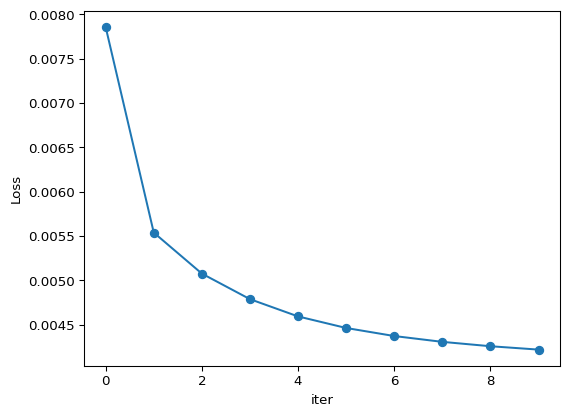

In [ ]:
plt.plot(mses, marker="o")
plt.xlabel("iter")
plt.ylabel("Loss")
plt.show()

MSE = 47.034


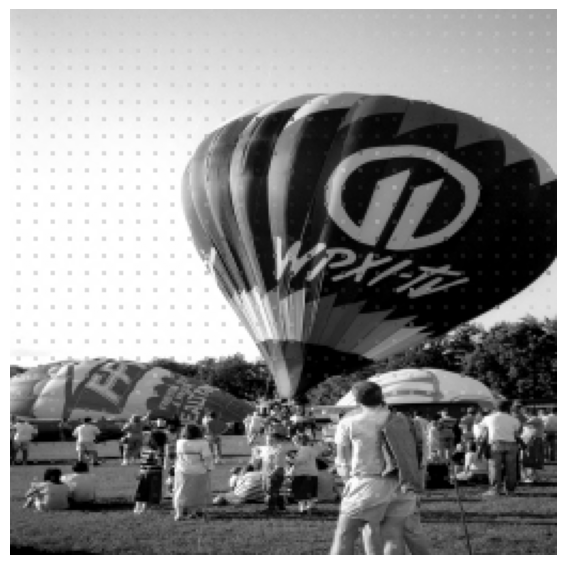

In [ ]:
img = cv.imread(join(img_path, "balloon.bmp"), cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (256, 256), cv.INTER_CUBIC)
img = img.astype(np.float64)

inps = []
tgts = []
do_parse_img(img, inps, tgts)

X_tst = np.zeros((len(inps), NUM_INP_NODES))
y_tst = np.zeros((len(tgts), NUM_OUT_NODES))
for idx in range(len(inps)):
  X_tst[idx, :] = inps[idx]
  y_tst[idx] = tgts[idx]

# predict the missing pixels
y_tst_prd = np.zeros(y_tst.shape)
for idx in range(X_tst.shape[0]):
  _, y_tst_prd[idx] = neural_response(X_tst[idx], wh, bh, wo, bo)

num_rows = img.shape[0]
num_cols = img.shape[1]
rec_img = np.zeros((num_rows, num_cols))

blk_pos = 0
for r0 in range(0, num_rows, BLOCK_SIZE):
  for c0 in range(0, num_cols, BLOCK_SIZE):
    # fill in the outer and context pixels
    for r in range(BLOCK_SIZE):
      for c in range(BLOCK_SIZE):
        assert(r0 + r < num_rows)
        assert(c0 + c < num_cols)
        if not is_missing_pixel(r, c):
          rec_img[r0 + r, c0 + c] = img[r0 + r, c0 + c]

    out = y_tst_prd[blk_pos]
    blk_pos += 1

    # fill in the missing pixels
    pos = 0
    for r in range(BLOCK_SIZE):
      for c in range(BLOCK_SIZE):
        assert(r0 + r < num_rows)
        assert(c0 + c < num_cols)
        if is_missing_pixel(r, c):
          rec_img[r0 + r, c0 + c] = 255*out[pos]
          pos += 1

# compute the MSE between the original and reconstructed images
err = rec_img - img
print(f"MSE = {(err**2).mean():.3f}")

imshow(rec_img, cmap="gray", dpi=45)
plt.show()